In [1]:
import tweepy
import re
import pymongo
from pymongo import MongoClient
import json
import pandas as pd
import emoji
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
import time

### ทำการดึงข้อมูลมาจาก mongodb แล้วมาทำ dataframe

In [2]:
client = MongoClient('localhost',27017)
db = client.tweet_db

In [3]:
db = client['tweet_db']

In [4]:
tweet_data = db.tweet_collectionV3

In [5]:
df = pd.DataFrame(list(tweet_data.find()))
df.head()

,_id,user_id,full_text,favorite_count,retweet_count,follower_count,all_hashtag,time
0,5e7411b70e6efd86094de16e,056Chompuu,ELLE บอกเด็กฝึกให้สอนภาษาเซชวนคำว่า จั่วย ให้ล...,1273,1286,7,/0319YouthWithLisa,Fri Mar 20 00:43:29 +0000 2020
1,5e7411b70e6efd86094de16f,LolaAfdila,คนนี้น่าจะเป็นคนญี่ปุ่นอ่ะแล้วลิซก็ถามคนนี้ว่า...,601,666,176,,Fri Mar 20 00:43:27 +0000 2020
2,5e7411b70e6efd86094de170,Samseeyah10,เดี๋ยวๆคู่นี้ก็ไม่ได้ทีมเดียวกันนะแต่ตัวติดกัน...,10,15,14,/0319YouthWithLalisa/LalisaManobal/Blackpink,Fri Mar 20 00:43:10 +0000 2020
3,5e7411b70e6efd86094de171,nongggjj9,Track List หลุดมาอีกรอบแล้วค่ะ อันนี้น่าจะดูเป...,71,102,367,,Fri Mar 20 00:43:09 +0000 2020
4,5e7411b70e6efd86094de172,OWongkamsak,คนนี้น่าจะเป็นคนญี่ปุ่นอ่ะแล้วลิซก็ถามคนนี้ว่า...,601,666,57,,Fri Mar 20 00:42:43 +0000 2020


In [6]:
df = df.drop(['_id'], axis=1)

In [7]:
df.head()

,user_id,full_text,favorite_count,retweet_count,follower_count,all_hashtag,time
0,056Chompuu,ELLE บอกเด็กฝึกให้สอนภาษาเซชวนคำว่า จั่วย ให้ล...,1273,1286,7,/0319YouthWithLisa,Fri Mar 20 00:43:29 +0000 2020
1,LolaAfdila,คนนี้น่าจะเป็นคนญี่ปุ่นอ่ะแล้วลิซก็ถามคนนี้ว่า...,601,666,176,,Fri Mar 20 00:43:27 +0000 2020
2,Samseeyah10,เดี๋ยวๆคู่นี้ก็ไม่ได้ทีมเดียวกันนะแต่ตัวติดกัน...,10,15,14,/0319YouthWithLalisa/LalisaManobal/Blackpink,Fri Mar 20 00:43:10 +0000 2020
3,nongggjj9,Track List หลุดมาอีกรอบแล้วค่ะ อันนี้น่าจะดูเป...,71,102,367,,Fri Mar 20 00:43:09 +0000 2020
4,OWongkamsak,คนนี้น่าจะเป็นคนญี่ปุ่นอ่ะแล้วลิซก็ถามคนนี้ว่า...,601,666,57,,Fri Mar 20 00:42:43 +0000 2020


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14296 entries, 0 to 14295
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_id         14296 non-null  object
 1   full_text       14296 non-null  object
 2   favorite_count  14296 non-null  int64 
 3   retweet_count   14296 non-null  int64 
 4   follower_count  14296 non-null  int64 
 5   all_hashtag     14296 non-null  object
 6   time            14296 non-null  object
dtypes: int64(3), object(4)
memory usage: 781.9+ KB


### ช่วงการ cleaning อีกรอบ
เนือกจาก เราใช้ .info() ดูข้อมูลที่เราได้มา พบว่าในส่วนของข้อมูล hashtags นั้นไม่มีค่า non <br/>
แต่เราเห็นว่าในส่วนนี้ข้อมูลมันไม่สมบูรณ์เลยเอาออกครับ และเช็ค full text ที่ user เดียวกันซ้ำอีกรอบ

In [9]:
df.duplicated(['user_id', 'full_text']).sum()

11

In [9]:
df.drop_duplicates(['user_id', 'full_text'], inplace=True)

In [10]:
df = df[df['all_hashtag'].map(lambda d: len(d)) > 0]

In [11]:
df

,user_id,full_text,favorite_count,retweet_count,follower_count,all_hashtag,time
0,056Chompuu,ELLE บอกเด็กฝึกให้สอนภาษาเซชวนคำว่า จั่วย ให้ล...,1273,1286,7,/0319YouthWithLisa,Fri Mar 20 00:43:29 +0000 2020
2,Samseeyah10,เดี๋ยวๆคู่นี้ก็ไม่ได้ทีมเดียวกันนะแต่ตัวติดกัน...,10,15,14,/0319YouthWithLalisa/LalisaManobal/Blackpink,Fri Mar 20 00:43:10 +0000 2020
9,lalali_lalaloy,19320 엑스포츠 news. #BLACKPINK #LISA ความงดงามที่...,503,583,150,/BLACKPINK/LISA,Fri Mar 20 00:41:42 +0000 2020
10,14113_,ชั้นล่ะขำแม่ อต. พ่กนางจะหวีดสำเนียงไอ่ลูกยันส...,478,595,15,/0319YouthWithLalisa/LalisaManobal,Fri Mar 20 00:41:41 +0000 2020
11,Lisabonus2,ลิซ่าให้กำลังใจเด็กฝึก ถ้าคุณสู้ต่อไป ไม่ท้อถอ...,1872,2224,53,/0319YouthWithLisa/YouthWithYouEP03/BLACKPINK,Fri Mar 20 00:41:31 +0000 2020
...,...,...,...,...,...,...,...
14289,onelalisanation,#LISA #BLACKPINK #YouthWithYou @ygofficialblink,832,539,17,/LISA/BLACKPINK/YouthWithYou,Thu Mar 19 07:54:00 +0000 2020
14290,f_film12,บอร์ดดิ้งพาส #JejuAir ของน้อง โปรเจควันเกิด LI...,413,298,133,/JejuAir/FlyHighwithLisa/LISA,Thu Mar 19 07:53:59 +0000 2020
14291,Paranee040776,สุดยอดอัลบั้มจาก Kpop หรือซิงเกิลที่ขายดีที่สุ...,247,267,122,/BLACKPINK,Thu Mar 19 07:53:58 +0000 2020
14293,FoxyLisalalice,ทุ่มนึงรึยังคะ? ไหนใครรอเมนเทอร์เสี่ยวลี่บ้าง ...,1609,1311,31,/HeartsForLisa,Thu Mar 19 07:53:53 +0000 2020


จากข้อมูลทั้งหมด 14,296 ในตอนนี้แรก สามารถใช้ได้จริง 9173

In [12]:
df.describe()

,favorite_count,retweet_count,follower_count
count,9173.000000,9173.000000,9173.000000
mean,973.357353,1028.347215,309.674479
std,1125.102805,951.750859,2748.668532
min,0.000000,0.000000,0.000000
25%,413.000000,313.000000,21.000000
50%,947.000000,888.000000,72.000000
75%,1872.000000,1559.000000,155.000000
max,38336.000000,24972.000000,213163.000000


เราใช้ pythainlp เข้ามาช่วยจัดการในข้อมูลที่เป็นภาษาไทย และกรองข้อมูลออกมาดู

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt 

In [14]:
def slash_tokenize(d):  
    result = d.split("/")
    result = list(filter(None, result))
    return result

def cleanText(text):
    text = str(text)
    text = re.sub('[^ก-๙]','',text)
    stop_word = list(thai_stopwords())
    sentence = word_tokenize(text , engine='newmm')
    result = [word for word in sentence if word not in stop_word and " " not in word]
    return " /".join(result)

def tokenize(d):  
    result = d.split("/")
    result = list(filter(None, result))
    return result

new_text = []
for txt in df["full_text"]:
    new_text.append(cleanText(txt))

hastag_data = df["all_hashtag"].dropna()
vectorizer = CountVectorizer(tokenizer=slash_tokenize)
transformed_data = vectorizer.fit_transform(hastag_data)
hash_tag_cnt_df= pd.DataFrame(columns = ['word', 'count']) 
hash_tag_cnt_df['word'] = vectorizer.get_feature_names()
hash_tag_cnt_df['count'] = np.ravel(transformed_data.sum(axis=0))
hash_tag_cnt_df.sort_values(by=['count'], ascending=False).head(20)

,word,count
20,blackpink,6100
3,0319youthwithlisa,4691
168,youthwithyouep03,3675
99,lisa,1901
2,0319youthwithlalisa,1123
90,lalisa,1012
93,lalisamanobal,596
165,youthwithyou,546
348,리사,453
54,heartsforlisa,348


นี้จะเป็น hashtags ที่อยู่กับ tweet ที่เกี่ยวข้องทั้งหมดซึ่ง ในช่วงนี้นั้นมีรายการหนึ่งพึ่งจัดขึ้น <br/>
ทำให้ 0319youthwithlisa และ youthwithyouep03 ที่เป็นเหตุการณ์ในรายการ มีการทวิตขึ้นมาด้วย <br/>
และอีกส่วนจะเป็นคำที่พบใน full_text ของทวิตมากที่สุด

In [15]:
vectorizer = CountVectorizer(tokenizer=tokenize)
transformed_data = vectorizer.fit_transform(new_text)
count_data = zip(vectorizer.get_feature_names(), np.ravel(transformed_data.sum(axis=0)))
keyword_df2 = pd.DataFrame(columns = ['word', 'count'])
keyword_df2['word'] = vectorizer.get_feature_names()
keyword_df2['count'] = np.ravel(transformed_data.sum(axis=0))   
keyword_df2.sort_values(by=['count'], ascending=False).head(20)

,word,count
929,ลิ,5966
312,ซ่า,5134
1365,เด็ก,3954
1382,เท,3263
676,ฝึก,3141
1434,เมน,2462
1194,อร,2453
1742,์,2445
428,ต่อไป,2009
1694,ให้กำลังใจ,2003


ทำการสร้าง wordclound ในการทำ visualization เพื่อแสดงถึงสิ่งที่ทำมาให้เป็นภาพ

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


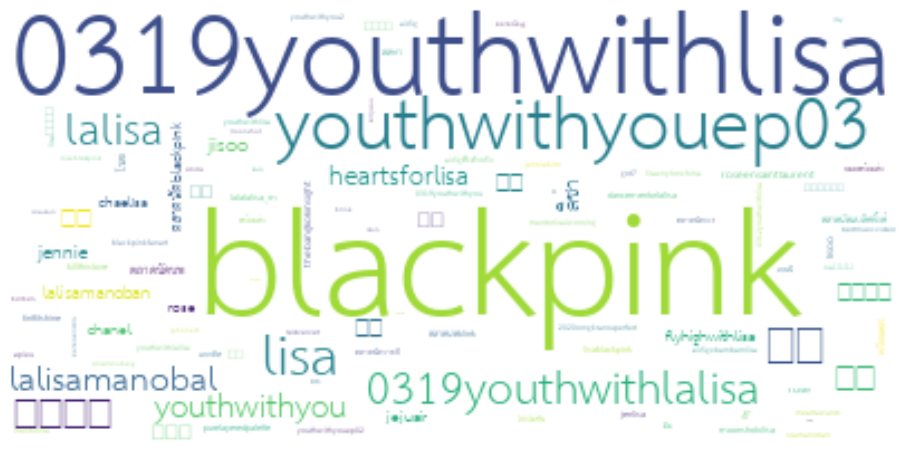

In [16]:
word_dict = {}
for i in range(0,len(keyword_df2)):
    try:
        word_dict[hash_tag_cnt_df.word[i]]= hash_tag_cnt_df['count'][i]
    except:
        pass
wordcloud = WordCloud(font_path='/content/THSarabunNew.ttf',background_color ='white',max_words=100).fit_words(word_dict)
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

C:\Users\ASUS\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


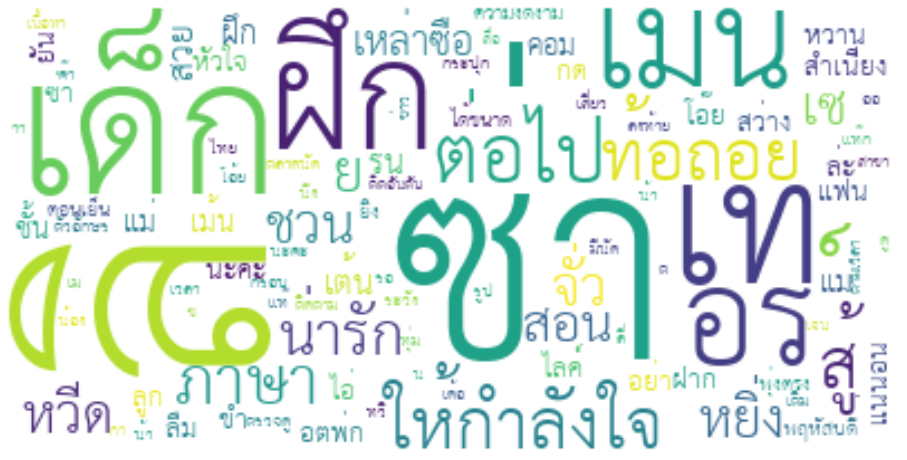

In [25]:
word_dict = {}
for i in range(0,len(keyword_df2)):
    word_dict[keyword_df2.word[i]]= keyword_df2['count'][i]
wordcloud = WordCloud(font_path='/content/THSarabunNew.ttf',background_color ='white',max_words=100).fit_words(word_dict)
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis("off")
fig.show()

### เลือก Column ที่ต้องการแล้วลองมาเรียงลำดับเพื่อดูยอดสูงสุดกัน

In [18]:
df.drop_duplicates("full_text").sort_values(by=['favorite_count'], ascending=False).head(10)[['full_text','favorite_count']]

,full_text,favorite_count
1521,พร้อมเข้าสู่ยุค 5G กับ AIS 5G ที่ดีที่สุดในไทย...,38336
6651,กุตายไปแร้วววววในจุดนี้ ฮึกก ลลิษาลู้กกกก #LAL...,6754
11332,โอ้ยกูขำน้องงงงงงงงงงง #รูปที่เซฟไว้ดูตอนเครีย...,5802
1298,วินาทีบีบหัวใจ คุณเมนเทอร์หลั่งน้ำตา ขณะกำลังใ...,5585
9217,#ROSÉ #BLACKPINK #BLACKPINK_HOUSE,4836
2953,Kick it ไม่เคยทำให้ผิดหวังค่ะ #BLACKPINKatTOKY...,4000
1363,เมื่อถามเมนเทอร์ลิซ่าว่า AKB48 มีสมาชิกอยู่กี่...,3909
888,สวยเหลือเกินทูลหัว,3684
6723,เด็กฝึกอยากนั่งใกล้เมนเทอร์ลิซ่าแต่พอสบตาแล้วก...,3650
12048,โมจิควบสองตำแหน่ง #BLACKPINK,3260


In [19]:
df.drop_duplicates("full_text").sort_values(by=['retweet_count'], ascending=False).head(10)[['full_text','retweet_count']]

,full_text,retweet_count
11332,โอ้ยกูขำน้องงงงงงงงงงง #รูปที่เซฟไว้ดูตอนเครีย...,24972
1521,พร้อมเข้าสู่ยุค 5G กับ AIS 5G ที่ดีที่สุดในไทย...,19683
9217,#ROSÉ #BLACKPINK #BLACKPINK_HOUSE,11674
13497,เมื่อ #CandyMafia บุกผับเกาหลี เต้นยับจ้า ใส่แ...,7582
6651,กุตายไปแร้วววววในจุดนี้ ฮึกก ลลิษาลู้กกกก #LAL...,7443
1363,เมื่อถามเมนเทอร์ลิซ่าว่า AKB48 มีสมาชิกอยู่กี่...,6493
1298,วินาทีบีบหัวใจ คุณเมนเทอร์หลั่งน้ำตา ขณะกำลังใ...,4968
6723,เด็กฝึกอยากนั่งใกล้เมนเทอร์ลิซ่าแต่พอสบตาแล้วก...,4832
2953,Kick it ไม่เคยทำให้ผิดหวังค่ะ #BLACKPINKatTOKY...,4269
12048,โมจิควบสองตำแหน่ง #BLACKPINK,4149


visualization แบบเป็น bar plot ที่ทำให้ดูได้ง่าย

C:\Users\ASUS\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ASUS\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ASUS\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ASUS\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49324 missing from current font.
  font.set_text(s, 0, flags=flags)


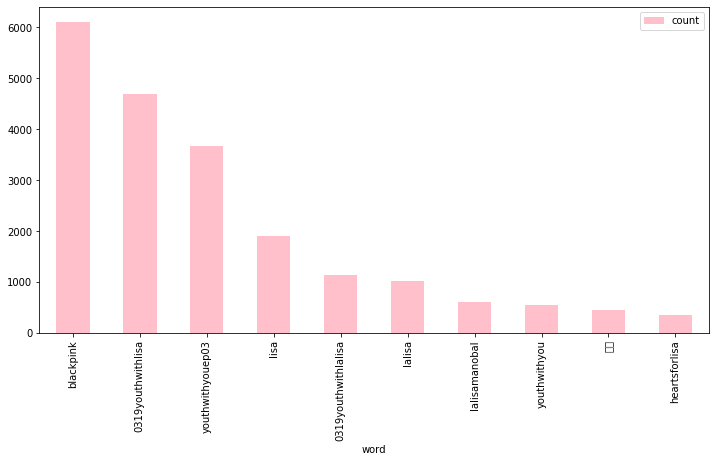

In [20]:
hash_tag_cnt_df.sort_values(by=['count'], ascending=False).set_index('word').head(10).plot(kind="bar",figsize=(12, 6) , color = 'pink')

In [22]:
df.sort_values(by=['time'])

,user_id,full_text,favorite_count,retweet_count,follower_count,all_hashtag,time
237,SFirdaw,19320 엑스포츠 news. #BLACKPINK #LISA ความงดงามที่...,503,583,10,/BLACKPINK/LISA,Fri Mar 20 00:00:04 +0000 2020
234,harmony_tata,เมนเทอร์ลิซ่าเทรนเต้นเด็กฝึก #0319YouthWithLis...,945,888,22,/0319YouthWithLisa/YouthWithYouEP03/BLACKPINK,Fri Mar 20 00:00:19 +0000 2020
232,parnpar24992576,19320 엑스포츠 news. #BLACKPINK #LISA ความงดงามที่...,503,583,10,/BLACKPINK/LISA,Fri Mar 20 00:01:18 +0000 2020
231,harmony_tata,เมนเทอร์ลิซ่าคอมเม้น #0319YouthWithLisa #Youth...,672,726,22,/0319YouthWithLisa/YouthWithYouEP03/BLACKPINK,Fri Mar 20 00:01:41 +0000 2020
230,relationpink35,19320 엑스포츠 news. #BLACKPINK #LISA ความงดงามที่...,503,583,102,/BLACKPINK/LISA,Fri Mar 20 00:02:05 +0000 2020
...,...,...,...,...,...,...,...
246,BPMyHappiness,ELLE บอกเด็กฝึกให้สอนภาษาเซชวนคำว่า จั่วย ให้ล...,1273,1286,116,/0319YouthWithLisa,Thu Mar 19 23:58:53 +0000 2020
244,Ppleng_BP,ชั้นล่ะขำแม่ อต. พ่กนางจะหวีดสำเนียงไอ่ลูกยันส...,478,595,252,/0319YouthWithLalisa/LalisaManobal,Thu Mar 19 23:59:23 +0000 2020
243,Sawena4,ชั้นล่ะขำแม่ อต. พ่กนางจะหวีดสำเนียงไอ่ลูกยันส...,478,595,0,/0319YouthWithLalisa/LalisaManobal,Thu Mar 19 23:59:28 +0000 2020
241,Nananungning95,ELLE บอกเด็กฝึกให้สอนภาษาเซชวนคำว่า จั่วย ให้ล...,1273,1286,102,/0319YouthWithLisa,Thu Mar 19 23:59:38 +0000 2020
